In [1]:
from glob import glob
from alchemlyb.parsing import namd
from alchemlyb.estimators import BAR
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from alchemlyb.visualisation.dF_state import plot_dF_state

In [ ]:
# USER PARAMETERS
plt.rcParams['figure.dpi'] = 150
temperature = 300

In [2]:
# up and down both start at L=0.5
u_nk_up = namd.extract_u_nk('upIDWS.fepout', temperature);
u_nk_down = namd.extract_u_nk('downIDWS.fepout', temperature);

u_nk = (-1*u_nk_down).append(u_nk_up) #make both lambda schedules consistent (0 to 1)

u_nk = u_nk.sort_index(level=1).sort_index(axis='columns') #sort the data so it can be interpreted by the BAR estimator

u_nk=u_nk[u_nk.columns[1:-1]] #Remove the one-way windows at either end

upIDWS.fepout: Forward-only window 0.5 0.55
upIDWS.fepout: IDWS window 0.55 0.6 0.5
upIDWS.fepout: IDWS window 0.6 0.65 0.55
upIDWS.fepout: IDWS window 0.65 0.7 0.6
upIDWS.fepout: IDWS window 0.7 0.75 0.65
downIDWS.fepout: Forward-only window 0.5 0.45
downIDWS.fepout: IDWS window 0.45 0.4 0.5
downIDWS.fepout: IDWS window 0.4 0.35 0.45
downIDWS.fepout: IDWS window 0.35 0.3 0.4
downIDWS.fepout: IDWS window 0.3 0.25 0.35


In [7]:
bar = BAR()
bar.fit(u_nk)

BAR()

In [8]:
# Extract data for plotting
states = bar.states_

f = bar.delta_f_.iloc[:,0] # dataframe
l = np.array([float(s) for s in states])
# lambda midpoints for each window
l_mid = 0.5*(l[1:] + l[:-1])

# FE differences are off diagonal
df = np.array([bar.delta_f_.iloc[i, i+1] for i in range(len(states)-1)])
print(df.cumsum() * 0.59)

# error estimates are too small because we use correlated data

tau = 5e3 # expected correlation length of series

# error estimates are off diagonal
ddf = np.array([bar.d_delta_f_.iloc[i, i+1] for i in range(len(states)-1)]) * np.sqrt(tau)

# Accumulate errors as sum of squares
errors = np.array([np.sqrt((ddf[:i]**2).sum()) for i in range(len(states))])
print("Errors", errors)

[0.18440183 0.38300418 0.47857887 0.47857887 0.47857887 0.39776574
 0.49031463 0.6661399 ]
Errors [0.         0.08297889 0.11596642 0.14320324 0.14320324 0.14320324
 0.20618205 0.25282001 0.29238672]


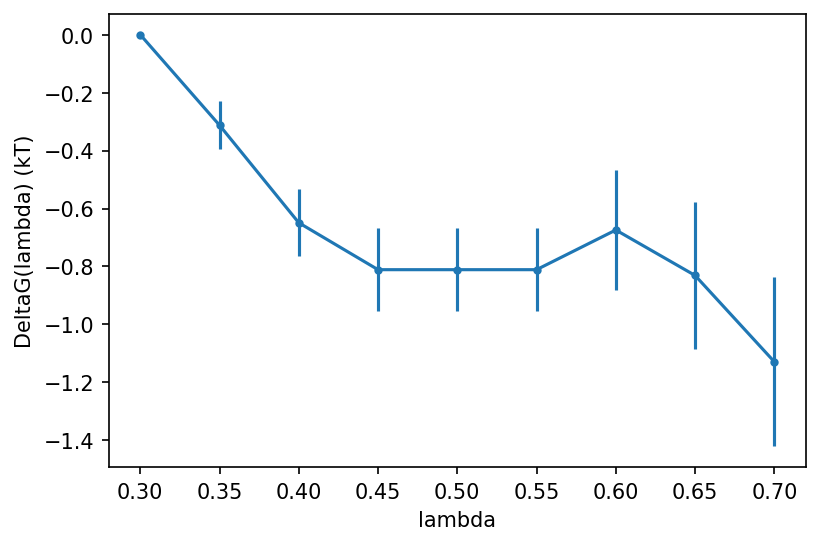

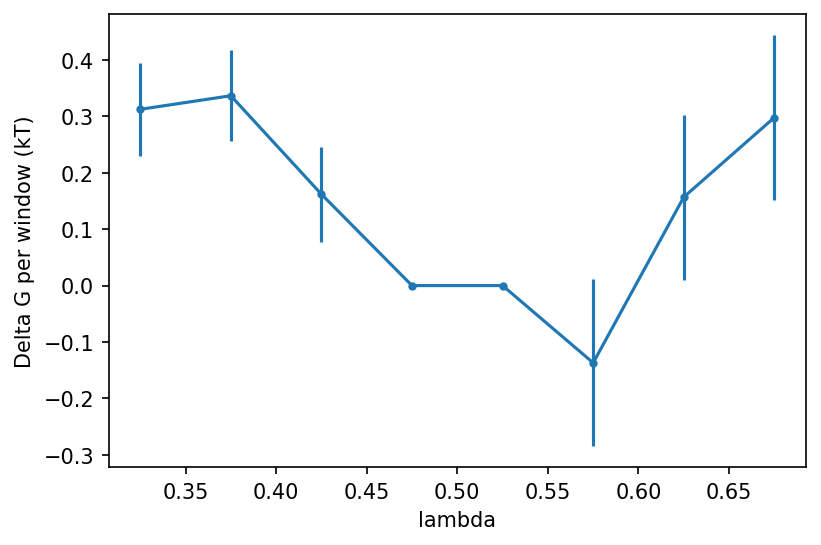

In [9]:
plt.errorbar(l, f, yerr=errors, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda) (kT)')
plt.show()

plt.errorbar(l_mid, df, yerr=ddf, marker='.')
plt.xlabel('lambda')
plt.ylabel('Delta G per window (kT)')
plt.show()

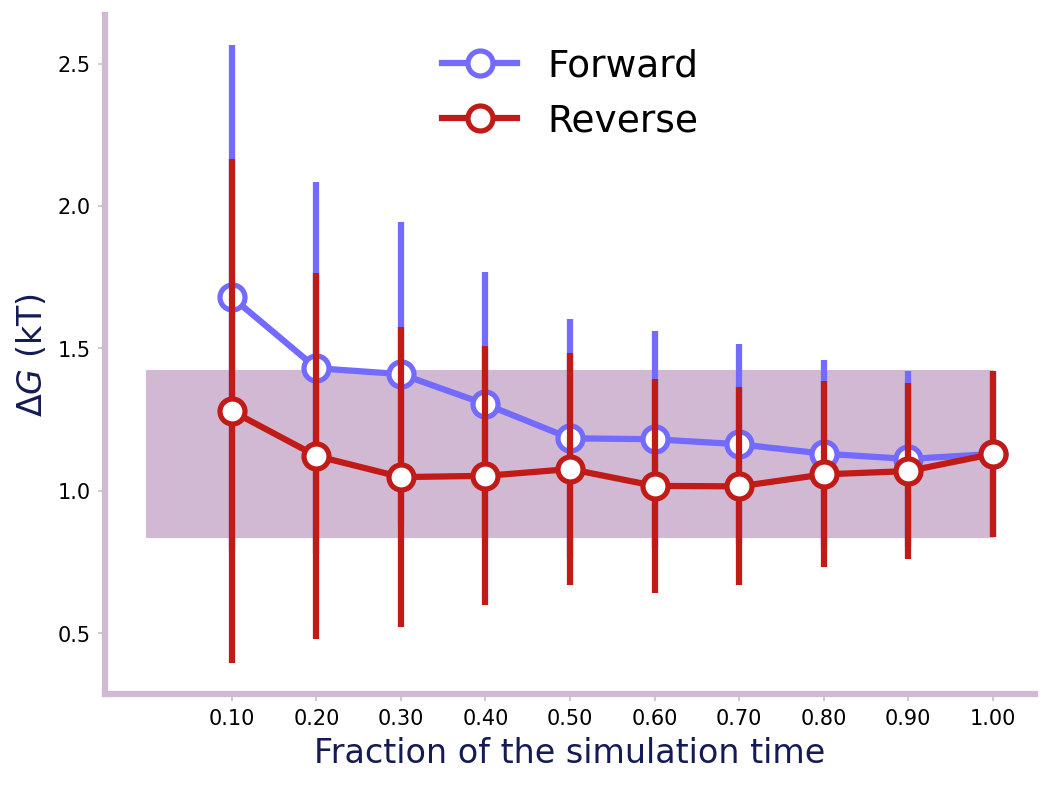

In [10]:
grouped = u_nk.groupby('fep-lambda')
data_list = [grouped.get_group(s) for s in states]

forward = []
forward_error = []
backward = []
backward_error = []
num_points = 10
for i in range(1, num_points+1):
    # forward
    partial = pd.concat([data[:int(len(data)/num_points*i)] for data in data_list])
    estimate = BAR().fit(partial)
    forward.append(estimate.delta_f_.iloc[0,-1])
    # For BAR, the error estimates are off-diagonal
    ddf = [estimate.d_delta_f_.iloc[i+1,i] * np.sqrt(tau) for i in range(len(states)-1)]
    error = np.sqrt((np.array(ddf)**2).sum())
    forward_error.append(error)

    # backward
    partial = pd.concat([data[-int(len(data)/num_points*i):] for data in data_list])
    estimate = BAR().fit(partial)
    backward.append(estimate.delta_f_.iloc[0,-1])
    ddf = [estimate.d_delta_f_.iloc[i+1,i] * np.sqrt(tau) for i in range(len(states)-1)]
    error = np.sqrt((np.array(ddf)**2).sum())
    backward_error.append(error)

from alchemlyb.visualisation import plot_convergence
ax = plot_convergence(forward, forward_error, backward, backward_error)
# ax.set_ylim(-40, -36)

In [11]:
#the data frame is organized from index level 1 (fep-lambda) TO column
#dG will be FROM column TO index
groups = u_nk.groupby(level=1)
dG=pd.DataFrame([])
for name, group in groups:
    dG[name] = np.log(np.mean(np.exp(-1*group)))
    
dG_f=np.diag(dG, k=1)
dG_b=np.diag(dG, k=-1)

l=dG.columns.to_list()
l_mid = np.mean([l[1:],l[:-1]], axis=0)

Text(0, 0.5, 'Diff. in delta-G')

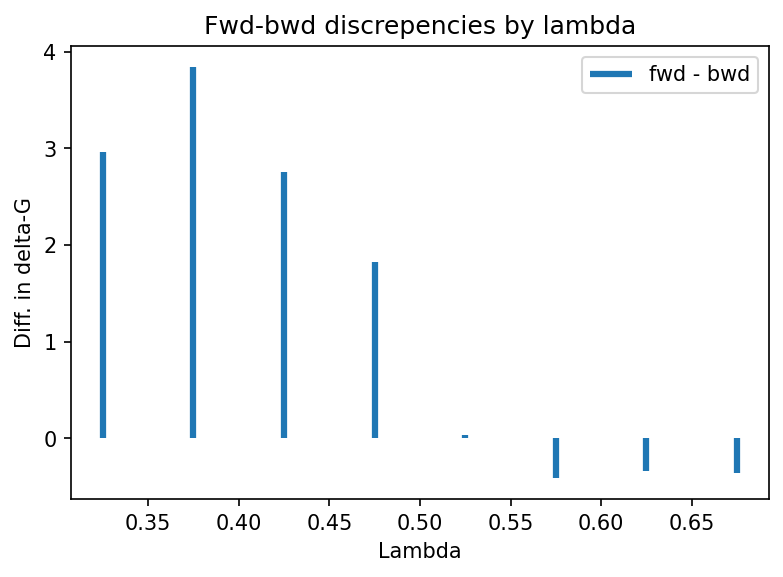

In [12]:
plt.vlines(l_mid, np.zeros(len(l_mid)), dG_f + np.array(dG_b), label="fwd - bwd", linewidth=3)

plt.legend()
plt.title('Fwd-bwd discrepencies by lambda')
plt.xlabel('Lambda')
plt.ylabel('Diff. in delta-G')

Text(0, 0.5, 'Count')

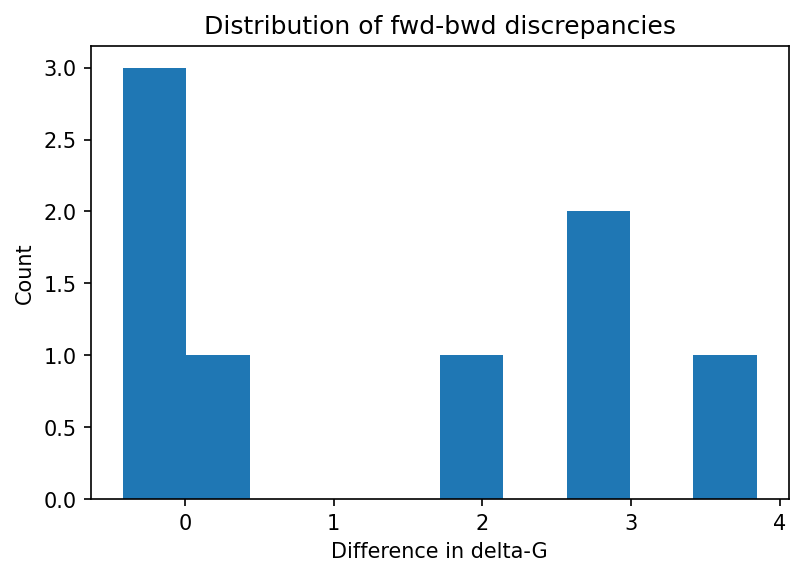

In [13]:
plt.hist(dG_f + np.array(dG_b));
plt.title('Distribution of fwd-bwd discrepancies')
plt.xlabel('Difference in delta-G')
plt.ylabel('Count')